In [7]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from modules.relax import RELAX
from main import SimCLR
from backbones import get_backbone
from evaluation import get_dataset

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
MODEL = "MICRA-Net"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False

if MODEL == "simclr-resnet18-STED":
    transform = None
    backbone = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    transform = None
    backbone = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
print(model)
print("Model loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SimCLR(
  (backbone): MICRANet(
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1,

/tmp/ipykernel_1176666/1075714521.py:33: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_1176666/1075714521.py:34: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_1176666/1075714521.py:40: UserWarning: Overwriting the cmap 'green-magenta' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_1176666/1075714521.py:41: UserWarning: Overwriting the cmap 'green-magenta_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)


In [8]:
dataset = get_dataset("factin-rings-fibers", transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=1,
    shuffle=True,
    num_workers=1
)

Dataset(F-actin) -- length: 50
rings - 25
fibers - 25



# Relax

In [9]:
out = defaultdict(list)
relax_list = []
num_batches, mask_bs = 32, 128
for i, (x, label) in enumerate(tqdm(dataloader)):
    if i >= 10:
        break
        
    x = x.to(DEVICE)
    with torch.no_grad():
        relax = RELAX(x, model.backbone, num_batches, mask_bs)
        relax.forward()
    relax_list.append({
        **label,
        "relax" : relax})

 20%|███████████████████████▌                                                                                              | 10/50 [00:53<03:33,  5.34s/it]


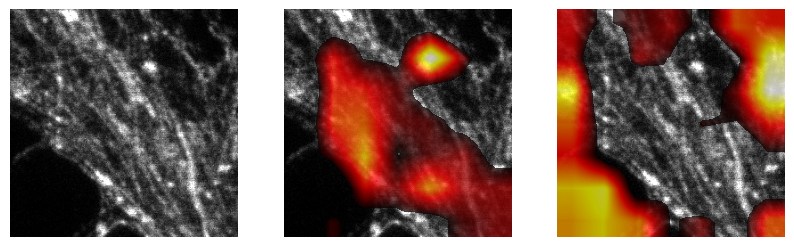

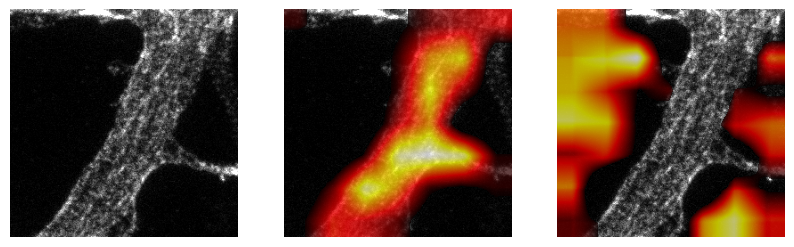

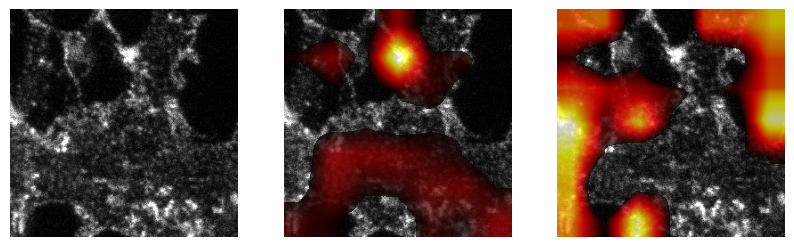

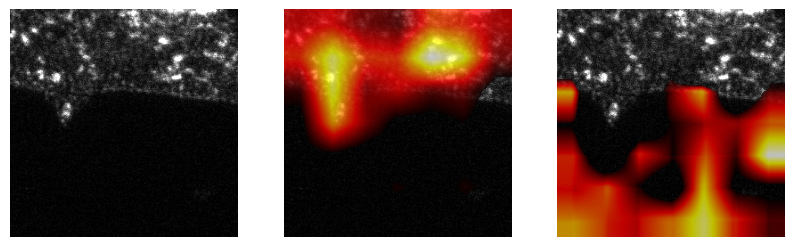

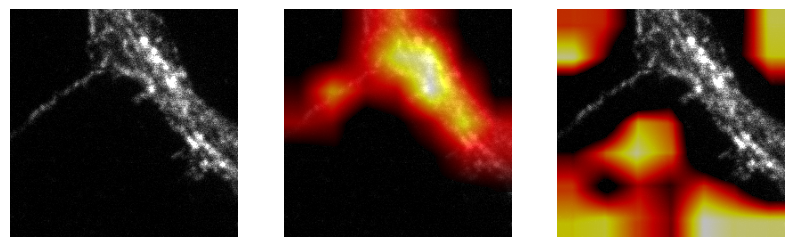

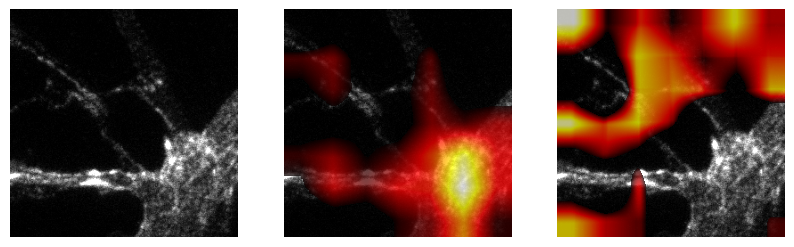

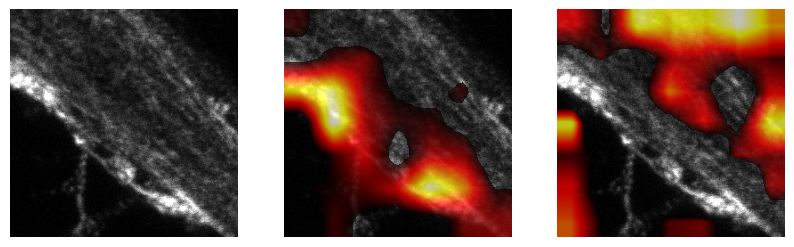

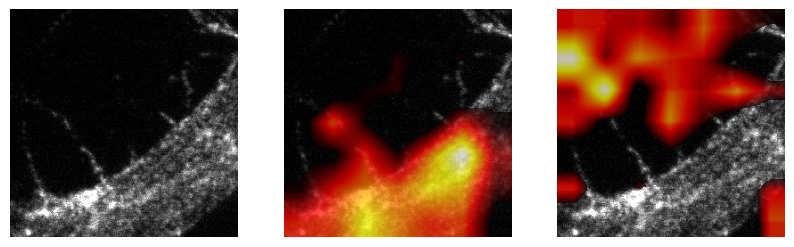

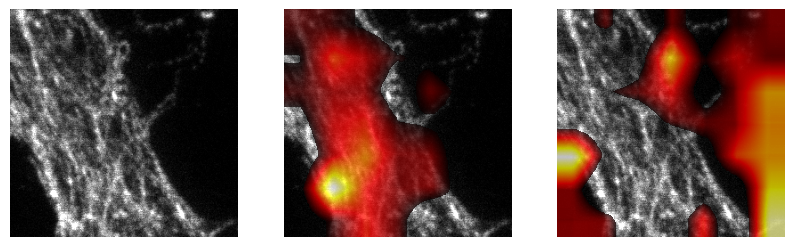

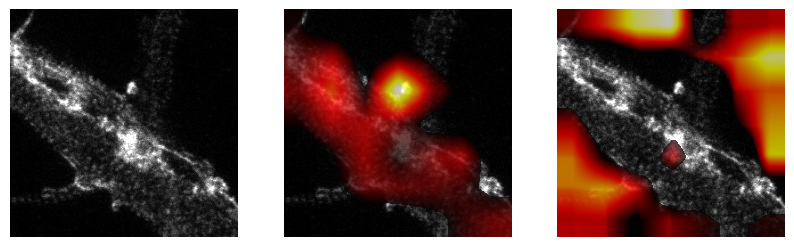

In [10]:

for data in relax_list:
    relax = data["relax"]
    idx = data["dataset-idx"].cpu().data.numpy()
    
    image = relax.x[0, 0].cpu().data.numpy()

    fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
    axes[0].imshow(image, vmin=numpy.quantile(image, 0.), vmax=numpy.quantile(image, 0.995), cmap="gray")
    axes[1].imshow(image, vmin=numpy.quantile(image, 0.), vmax=numpy.quantile(image, 0.995), cmap="gray")
    masked_importance = relax.importance().cpu().data.numpy()
    masked_importance[masked_importance < numpy.median(masked_importance)] = numpy.nan
    axes[1].imshow(masked_importance, cmap="hot", alpha=0.75)
    axes[2].imshow(image, vmin=numpy.quantile(image, 0.), vmax=numpy.quantile(image, 0.995), cmap="gray")    
    masked_uncertainty = relax.uncertainty().cpu().data.numpy()
    masked_uncertainty[masked_uncertainty < numpy.median(masked_uncertainty)] = numpy.nan
    axes[2].imshow(masked_uncertainty, cmap="hot", alpha=0.75)    
    for ax in axes.ravel():
        ax.axis("off")
    pyplot.show()